# Install required package.

In [28]:
!pip install keras tensorflow

# Inception-v3 in Keras

It is quite easy to use a pre-trained model in Keras, only two lines as follows.

This model was pre-trained with ImageNet’s datasets, which has one million images and 1000 classes.

![](https://cdn-images-1.medium.com/max/1600/1*ZCXqy5c-MwRzJlo7rYPyRQ.png)

In [7]:
from keras.applications.inception_v3 import InceptionV3
model = InceptionV3(weights='imagenet')

In [8]:
# Inline display image
from IPython.display import display

# Imports Keras packages and model
import numpy as np
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions


Let’s classify following two images with this model. Since Inception-v3 model accepts RGB 299x299 image as input, you must convert your image before classify it.

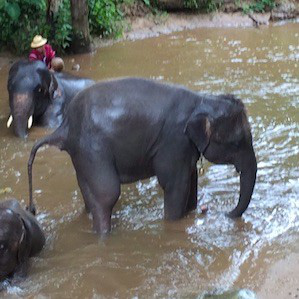

Predicted:
Score 0.9574729204177856, Label Indian_elephant
Score 0.023402594029903412, Label tusker
Score 0.0008965737652033567, Label African_elephant
Score 0.0005087102763354778, Label Mexican_hairless
Score 0.0003765019937418401, Label hippopotamus


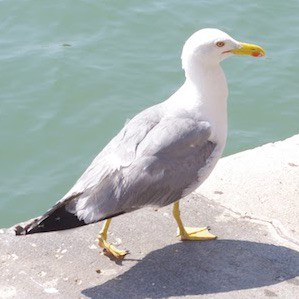

Predicted:
Score 0.27089518308639526, Label albatross
Score 0.04000930115580559, Label drake
Score 0.02090652659535408, Label lakeside
Score 0.020727239549160004, Label goose
Score 0.018617119640111923, Label red-breasted_merganser


In [24]:
def predict(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Display image
    display(img)
    
    # Classify image
    preds = model.predict(x)
    
    # Print predicted classes
    print('Predicted:')
    for p in decode_predictions(preds, top=5)[0]:
        print("Score {}, Label {}".format(p[2], p[1]))    

        
predict('Indian_elephant.jpeg')
predict('Gull.jpeg')        

The model classified elephants correctly, but failed to classify a seagull. The reason is simply because datasets for training the model doesn’t include “gull”, so that it classified similar candidates instead. You never get results out of the list, and that’s why transfer learning is needed.

# Visualize intermediate layer outputs

Before going to transfer learning, let’s visualize intermediate layer outputs. To show list of layers, run the code below.

In [35]:
import matplotlib
import matplotlib.pyplot as plt

# Will allow us to embed images in the notebook
%matplotlib inline

import pandas as pd
pd.DataFrame(model.layers).tail()


,0
308,<keras.layers.merge.Concatenate object at 0x14...
309,<keras.layers.core.Activation object at 0x14ca...
310,<keras.layers.merge.Concatenate object at 0x14...
311,<keras.layers.pooling.GlobalAveragePooling2D o...
312,<keras.layers.core.Dense object at 0x14c9d5240>


We want to visualize outputs of layer 311, `GlobalAveragePooling2D`, so let’s construct a model to output the intermediate layer outputs.

In [14]:
from keras.models import Model

# The model which outputs intermediate layer features
intermediate_layer_model = Model(inputs=model.input, 
                                 outputs=model.layers[311].output)

To extract features and visualize, run the following code.

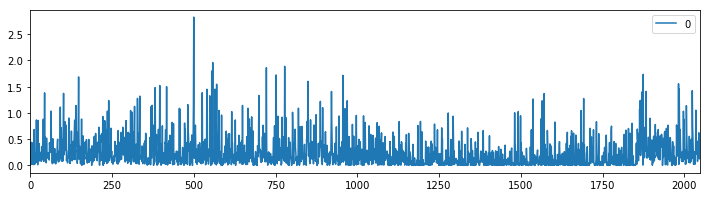

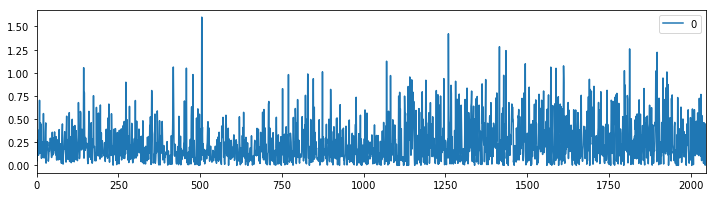

In [36]:
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Display image
    display(img)
    
    # Extract features
    features = intermediate_layer_model.predict(x)

    # Visualize
    pd.DataFrame(features.reshape(-1,1)).plot(figsize=(12, 3))
    
extract_features('Indian_elephant.jpeg')
extract_features('Gull.jpeg')

The outputs of `GlobalAveragePooling2D` are 2048 dimensions features. Inception-v3 model classifies 1000 classes by using Dense layer at the end of the network, which uses these features as input. But now, we would like to classify “other” classes. So let’s remove this layer and put another one.

# Add Dense layers for fine tuning

Let’s add dense layers, if we want to classify **two-classes**, the code would be something like this.

In [40]:
from keras.layers import Dense

# Connect Dense layers at the end
x = intermediate_layer_model.output
x = Dense(1024, activation='relu')(x)
# two-classes
predictions = Dense(2, activation='softmax')(x)

# Transfer Learning model
transfer_model = Model(inputs=intermediate_layer_model.input, outputs=predictions)

pd.DataFrame(transfer_model.layers).tail()

,0
309,<keras.layers.core.Activation object at 0x14ca...
310,<keras.layers.merge.Concatenate object at 0x14...
311,<keras.layers.pooling.GlobalAveragePooling2D o...
312,<keras.layers.core.Dense object at 0x13c0a6ba8>
313,<keras.layers.core.Dense object at 0x118f5f978>


At this moment, the model trains all its variables. But we want to train only the dense layers we added, so let’s freeze untrained layers.

In [41]:
# Freeze all layers
for layer in transfer_model.layers:
    layer.trainable = False

# Unfreeze last dense layers
transfer_model.layers[312].trainable = True
transfer_model.layers[313].trainable = True

transfer_model.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

Done! Now we can fine-tune this model for dedicated two-classes classification.

Fine tuning for two-classes classification
Let’s classify the images below. the datasets is named Opera-Capitol datasets, which includes Opera house and Capitol 100 images for each. You can download the code to make this datasets.
https://github.com/hayatoy/deep-learning-datasets

![](https://cdn-images-1.medium.com/max/1600/1*iHxe57geQ_CkXsdYnu-ZWw.png)

# Load dataset

The dataset is compressed as NumPy format and stored in GitHub, you can use it as follows.

In [44]:
import requests
from io import BytesIO

url = 'https://github.com/hayatoy/deep-learning-datasets/releases/download/v0.1/tl_opera_capitol.npz'
response = requests.get(url)
dataset = np.load(BytesIO(response.content))

X_dataset = dataset['features']
y_dataset = dataset['labels']

Let’s split the dataset into for train and for test, here I split it 80% for train and 20% for test.

In [45]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

X_dataset = preprocess_input(X_dataset)
y_dataset = np_utils.to_categorical(y_dataset)
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset, y_dataset, test_size=0.2, random_state=42)

# Fine tuning the model for Opera-Capitol

To train the transfer learning model, just call `fit` function. After that, let’s evaluate the model how it predict correctly.

In [46]:
transfer_model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_test, y_test))
loss, acc = transfer_model.evaluate(X_test, y_test)
print('Loss {}, Accuracy {}'.format(loss, acc))

Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 169s 1s/step - loss: 1.3284 - acc: 0.6125 - val_loss: 0.4810 - val_acc: 0.7500
Epoch 2/20
160/160 [==============================] - 146s 913ms/step - loss: 0.3680 - acc: 0.8500 - val_loss: 1.0037 - val_acc: 0.5500
Epoch 3/20
160/160 [==============================] - 122s 761ms/step - loss: 0.1884 - acc: 0.9437 - val_loss: 0.4309 - val_acc: 0.8500
Epoch 4/20
160/160 [==============================] - 115s 720ms/step - loss: 0.0752 - acc: 0.9813 - val_loss: 0.3431 - val_acc: 0.8750
Epoch 5/20
160/160 [==============================] - 110s 685ms/step - loss: 0.0511 - acc: 0.9938 - val_loss: 0.5445 - val_acc: 0.8500
Epoch 6/20
160/160 [==============================] - 108s 678ms/step - loss: 0.0253 - acc: 0.9938 - val_loss: 0.3653 - val_acc: 0.9000
Epoch 7/20
160/160 [==============================] - 108s 676ms/step - loss: 0.0305 - acc: 0.9813 - val_loss: 0.3404 - val_acc: 0.9000
Epoch 